# Phase 2: Classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/methylation')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install h5py==2.10.0

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorflow_version 1
#Start tensorboard
%tensorboard — logdir logs
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-data-dir PATH]
tensorboard: error: unrecognized ar

In [ ]:
seed = 0
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)

In [ ]:
%matplotlib inline  

import imp
import numpy as np
import os
import keras
import keras.backend
import keras.models
import sklearn
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras import regularizers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import keras.models as mod
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
from sklearn.externals import joblib

Using TensorFlow backend.


In [ ]:
%tensorflow_version 1
seed=0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
seed=0      #Initially 0
np.random.seed(seed)
df = pd.read_csv('dataset/genelevelMethyl.csv', index_col=0)
df = df.reindex(sorted(df.columns), axis=1)
df=df.T
print("CNV Matrix Before:", df.shape)

df2=pd.read_csv('./dataset/BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '.') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]

commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes]
df2=df2.loc[commonIndexes] 

print("CNV After:", df.shape)
print("Clinical Data After:", df2.shape)
print("CNV and Clinical Data corresponds to same Patients: ", False if False in (df.index==df2.index) else True)
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True)
print("Labels", unique_elements, counts_elements)

CNV Matrix Before: (888, 22382)
Clinical Data Before: (1247, 202)
CNV After: (620, 22382)
Clinical Data After: (620, 202)
CNV and Clinical Data corresponds to same Patients:  True
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [ ]:
X=np.array(df.values)

In [ ]:
Y_temp=np.array(df2.values[:,k])
print("TARGET LABEL SIZE BEFORE: ", Y_temp.shape)
label_encoder=LabelEncoder()
Y=label_encoder.fit_transform(Y_temp)
print("TARGET LABEL SIZE BEFORE: ", Y.shape)
print("Labels before and after:", Y_temp[0:9], Y[0:9])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

TARGET LABEL SIZE BEFORE:  (620,)
TARGET LABEL SIZE BEFORE:  (620,)
Labels before and after: ['Normal' 'LumA' 'LumA' 'LumA' 'LumA' 'LumB' 'LumA' 'Basal' 'LumA'] [4 2 2 2 2 3 2 0 2]
{'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3, 'Normal': 4}


In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
Y = Y.reshape(len(Y), 1)
Y_onehot = onehot_encoder.fit_transform(Y)
print(Y_onehot.shape)

(620, 5)


In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [ ]:
folds = [[0]*2 for i in range(5)]

In [ ]:
i = 0

for train, test in skf.split(X, Y):
  folds[i][0] =  train
  folds[i][1] = test
  i += 1

In [ ]:
fold_no = 1

train_idx = folds[fold_no][0]
test_idx = folds[fold_no][1]

X_train = X[train_idx]
Y_train = Y_onehot[train_idx]
X_test = X[test_idx]
Y_test = Y_onehot[test_idx]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((496, 22382), (496, 5), (124, 22382), (124, 5))

In [ ]:
sm=SMOTE(random_state=seed)
#X_train1, Y_train1 = X_train, Y_train
#X_train, X_val,Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=seed) 

X_train_res,Y_train_res=sm.fit_sample(X_train,Y_train)
X_train_res.shape, Y_train_res.shape

((1155, 22382), (1155, 5))

In [ ]:
from keras.models import model_from_json

json_file=open("results_5fold/encoder"+str(fold_no)+".json",'r') 
loaded_model_json = json_file.read()
json_file.close()
encoder2 = model_from_json(loaded_model_json) 

encoder2.load_weights("results_5fold/encoder"+str(fold_no)+".h5")
encoded_data_train=encoder2.predict(X_train_res)
#encoded_data_val=encoder2.predict(X_val)
encoded_data_test = encoder2.predict(X_test)
print("Train and Test Dimensions after Encoding 20,000->compact representation")
encoded_data_train.shape, encoded_data_test.shape

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train and Test Dimensions after Encoding 20,000->compact representation


((1155, 500), (124, 500))

In [ ]:
fold_no

1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputNN (InputLayer)         (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
lrc (ReLU)                   (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0   

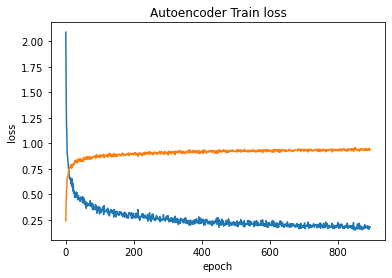

In [ ]:

from keras.layers import LeakyReLU, Softmax, ReLU
drpRate1=0.2
drpRate=0.3
np.random.seed(seed)

input_dim=encoded_data_train.shape[1]
input_layer2=Input(shape=(input_dim,),name='inputNN')
hidden1=BatchNormalization()(input_layer2)  
hidden2=Dropout(drpRate1, seed=seed)(hidden1)
hidden3=Dense(200,activation=None)(hidden2)
hidden30=ReLU(name='lrc')(hidden3)
hidden4=BatchNormalization()(hidden30) 
hidden5=Dropout(drpRate, seed=seed)(hidden4)
output2=Dense(5, name='outputNN')(hidden5)
softmax=Softmax()(output2)
classifier=Model(inputs=input_layer2,outputs=softmax)
print(classifier.summary())

adam=Adam(lr=0.00002)
classifier.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, mode='min', verbose=1,patience=50)   
# Fit the model
history=classifier.fit(encoded_data_train,Y_train_res,epochs=895,batch_size=8,shuffle=True,     
                      #validation_data = (encoded_data_test, Y_test),  
                      #callbacks=[es],
                      verbose=2)
                
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_accuracy'])
plt.title('Autoencoder Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train loss', 'train acc', 'val loss', 'val acc'], loc='upper right')
plt.show()

In [ ]:
encoded_data=encoder2.predict(X_train)
train_score=classifier.evaluate(encoded_data, Y_train)
print("\nTraining Accuracy %s: %.2f%%" % (classifier.metrics_names[1], train_score[1]*100))

encoded_data=encoder2.predict(X_test)

test_score=classifier.evaluate(encoded_data, Y_test) 
print("\nTesting Accuracy %s: %.2f%%" % (classifier.metrics_names[1], test_score[1]*100)) 

496/496 [==============================] - 0s 213us/step

Training Accuracy accuracy: 96.98%
124/124 [==============================] - 0s 124us/step

Testing Accuracy accuracy: 78.23%


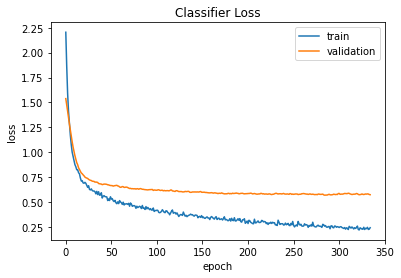

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.savefig('results/classifier_loss.png')

plt.show()

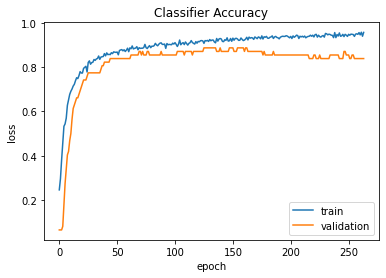

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.savefig('results/classifier_acc.png')

plt.show()

In [ ]:
model_json=classifier.to_json()
with open("results/classifierBRCA.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
encoded_data=encoder2.predict(X_test)
y_pred=classifier.predict(encoded_data)
y_pred=np.argmax(y_pred,axis=-1).reshape(-1,1)
y_true=np.argmax(Y_test,axis=-1).reshape(-1,1)

cm=confusion_matrix(y_pred,y_true)
cm.T

array([[17,  0,  0,  0,  0],
       [ 1,  2,  1,  2,  0],
       [ 0,  0, 48,  7,  2],
       [ 0,  0, 12, 14,  0],
       [ 0,  1,  1,  0, 16]])

<Figure size 432x288 with 0 Axes>

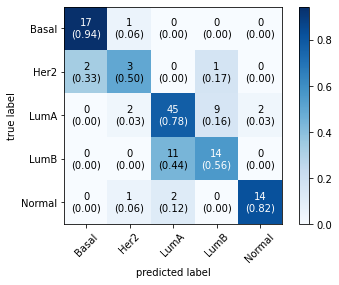

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
!pip install mlxtend --upgrade --no-deps 
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=cm.T,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True, class_names = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal'])
#plt.show()
#plt.savefig('/content/drive/My Drive/autoencoder/BRCA/CMPhase1.png', bbox_inches = 'tight', dpi = 600)